## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = 1000

In [6]:
DOMAIN = 'openoffice'
METHOD = 'baseline_{}'.format(epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, \
                                                                                             METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [7]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
import keras.backend as K

MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]
MAX_SEQUENCE_LENGTH_I = K.int_shape(similarity_model.input[2])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, MAX_SEQUENCE_LENGTH_I

(20, 20, 94)

In [9]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_status': 2, 'component': 52, 'priority': 6, 'version': 34}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


#### Loading bug ids in memory

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


115814

#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 9.77 s, sys: 1.03 s, total: 10.8 s
Wall time: 10.7 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


Reading train data
Reading bug ids
CPU times: user 3min 24s, sys: 43.3 ms, total: 3min 24s
Wall time: 3min 24s


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)
len(bug_train_ids)

CPU times: user 24 ms, sys: 3.95 ms, total: 27.9 ms
Wall time: 27.7 ms


In [18]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path="test_chronological")

Reading test data for classification
CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 28 ms


In [19]:
len(baseline.test_data)

16909

## Siamese  model

In [20]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [21]:
from keras.layers import concatenate, Dropout, Add

bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder(bug_t_a)
bugt_d_a = desc_encoder(bug_d_a)
bugt_i_a = info_encoder(bug_i_a)
# Bug B
bugt_t_b = title_encoder(bug_t_b)
bugt_d_b = desc_encoder(bug_d_b)
bugt_i_b = info_encoder(bug_i_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
#     x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a, bug_t_b, bug_d_a, bug_d_b, bug_i_a, bug_i_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 94)           0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
info_b (InputLayer)             (None, 94)           0                                            
__________________________________________________________________________________________________
title_b (I

In [22]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets
                                                                                    )
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [23]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [24]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [25]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [26]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 

Epoch 1/100
10/10 [==============================] - 3s 253ms/step - loss: 0.5485 - acc: 0.7075 - val_loss: 0.4467 - val_acc: 0.7578
Epoch 2/100
10/10 [==============================] - 1s 115ms/step - loss: 0.4447 - acc: 0.7693 - val_loss: 0.3882 - val_acc: 0.7695
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.4332 - acc: 0.772 - 1s 85ms/step - loss: 0.4333 - acc: 0.7716 - val_loss: 0.3542 - val_acc: 0.8164
Epoch 4/100
10/10 [==============================] - 1s 86ms/step - loss: 0.4089 - acc: 0.7869 - val_loss: 0.3471 - val_acc: 0.8262
Epoch 5/100
10/10 [==============================] - 1s 116ms/step - loss: 0.4087 - acc: 0.7889 - val_loss: 0.3443 - val_acc: 0.8203
Epoch 6/100
10/10 [==============================] - 1s 75ms/step - loss: 0.3862 - acc: 0.8074 - val_loss: 0.3151 - val_acc: 0.8730
Epoch 7/100
10/10 [==============================] - 1s 105ms/step - loss: 0.3810 - acc: 0.8131 - val_loss: 0.3001 - val_acc: 0.8691
Epoch 8/100
10/10 [===============

Epoch 62/100
10/10 [==============================] - 1s 97ms/step - loss: 0.3130 - acc: 0.8566 - val_loss: 0.2369 - val_acc: 0.9023
Epoch 63/100
10/10 [==============================] - 1s 117ms/step - loss: 0.3007 - acc: 0.8629 - val_loss: 0.2408 - val_acc: 0.9023
Epoch 64/100
10/10 [==============================] - 1s 117ms/step - loss: 0.2949 - acc: 0.8637 - val_loss: 0.2380 - val_acc: 0.9004
Epoch 65/100
10/10 [==============================] - 1s 88ms/step - loss: 0.3146 - acc: 0.8561 - val_loss: 0.2371 - val_acc: 0.8965
Epoch 66/100
10/10 [==============================] - 1s 106ms/step - loss: 0.3065 - acc: 0.8583 - val_loss: 0.2373 - val_acc: 0.9062
Epoch 67/100
10/10 [==============================] - 1s 107ms/step - loss: 0.2999 - acc: 0.8619 - val_loss: 0.2275 - val_acc: 0.9180
Epoch 68/100
10/10 [==============================] - 1s 113ms/step - loss: 0.3036 - acc: 0.8614 - val_loss: 0.2265 - val_acc: 0.9043
Epoch 69/100
10/10 [==============================] - 1s 109ms/s

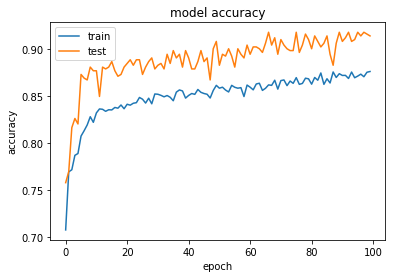

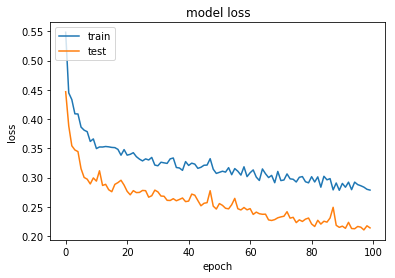

In [27]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [28]:
result = { }

In [29]:
number_of_pairs = len(baseline.test_data)

#### train

In [30]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
acc_train

0.8821268038798202

#### test

In [31]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
acc_test

0.7838541666666666

### Roc AUC/SCORE

#### train

In [32]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_train = roc_auc_score(y_true, y_scores)
roc_train

0.9575754011648729

#### test

In [33]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_test = roc_auc_score(y_true, y_scores)
roc_test

0.8510403103298609

#### Confusion Matrix

https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

In [34]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

[1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


In [35]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,


Normalized confusion matrix
[[0.84375    0.15625   ]
 [0.27604167 0.72395833]]


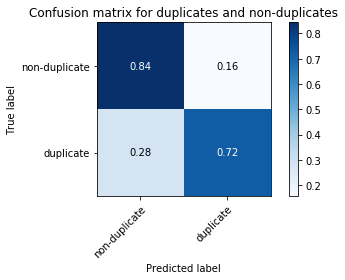

In [36]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")

#### Save the model

In [37]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [38]:
import _pickle as pickle

CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.
